# Road Segmentation

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.metrics import MeanIoU, Accuracy

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import numpy as np

def extract_padded_patches(image, patch_size=(512, 512)):
    height, width = image.shape[:2]
    patch_height, patch_width = patch_size

    num_patches_y = (height + patch_height - 1) // patch_height
    num_patches_x = (width + patch_width - 1) // patch_width

    # Calculate padding
    pad_y = num_patches_y * patch_height - height
    pad_x = num_patches_x * patch_width - width

    # Pad the image
    padded_image = np.pad(image, ((0, pad_y), (0, pad_x), (0, 0)), mode='constant')
    #print(padded_image.shape)
    
    # Extract patches
    patches = []

    for y in range(0, num_patches_y * patch_height, patch_height):
        for x in range(0, num_patches_x * patch_width, patch_width):
            patch = padded_image[y:y+patch_height, x:x+patch_width]
            #plt.imshow(patch/255)
            patches.append(patch)

    return np.array(patches)

In [5]:
#load the .npz file
def load_images(path,name, labels):
    npzfile=np.load(path+"{}.npz".format(name))
    images=npzfile['arr_0']
    del npzfile
    


    npzfile=np.load(path+"{}.npz".format(labels))
    labels=npzfile['arr_0']
    del npzfile
    
    return np.array(images),  np.reshape(np.array(labels), (-1, 512, 512, 1))

In [6]:
# import matplotlib.pyplot as plt

# # Assume 'patches' is a list of images obtained from extract_padded_patches function

# # Create a figure with subplots
# fig, axs = plt.subplots(1, len(patches), figsize=(15, 5))

# # Iterate through patches and display them
# for i, patch in enumerate(patches):
#     axs[i].imshow(patch/255)
#     axs[i].axis('off')
#     axs[i].set_title(f'Patch {i + 1}')

# # Show the plot
# plt.show()

In [7]:
path='E:\\Pavithra\\road\\'


x_train,y_train = load_images(path,'train_new_images_patches_300','train_labels_new_patches_300')
print(x_train.shape, y_train.shape)


x_val,y_val = load_images(path,'val_images_patches','val_labels_patches')
print(x_val.shape, y_val.shape)

x_test,y_test = load_images(path,'test_images_patches','test_labels_patches')
print(x_test.shape, y_test.shape)

x_train.sort()
y_train.sort()

x_val.sort()
y_val.sort()

x_test.sort()
y_test.sort()

#print(len(x_train), len(y_train))#, len(x_test), len(y_test))



(2700, 512, 512, 3) (2700, 512, 512, 1)
(126, 512, 512, 3) (126, 512, 512, 1)
(441, 512, 512, 3) (441, 512, 512, 1)


In [8]:
from tensorflow.keras.utils import Sequence
import numpy as np 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 1)
val_gen = DataGenerator(x_val, y_val, 1)


In [9]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(2700, 512, 512, 3) (2700, 512, 512, 1) (126, 512, 512, 3) (126, 512, 512, 1) (441, 512, 512, 3) (441, 512, 512, 1)


In [10]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
gpu_devices = [x for x in local_device_protos if x.device_type == 'GPU']

for gpu_device in gpu_devices:
    print("Name:", gpu_device.name)
    print("Memory:", gpu_device.memory_limit)

Name: /device:GPU:0
Memory: 6330253312


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def combine_images_rgb(images, num_samples=9):
    # Create an empty array to store the combined image
    combined_image = np.zeros((1536, 1536,3))

    # Calculate the number of rows and columns for the grid
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))

    # Iterate over the images and place them in the combined image array
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        start_row = row * 512
        end_row = start_row + 512
        start_col = col * 512
        end_col = start_col + 512
        combined_image[start_row:end_row, start_col:end_col] = images[i] / 255

    return combined_image

# Combine the first 9 ground truth images
combined_image = combine_images_rgb(x_test[0:9])

# Plot the combined image
plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()
plt.imsave('new.png', combined_image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def combine_images_gray(images, num_samples=9):
    # Create an empty array to store the combined image
    combined_image = np.zeros((1536, 1536))

    # Calculate the number of rows and columns for the grid
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))

    # Iterate over the images and place them in the combined image array
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        start_row = row * 512
        end_row = start_row + 512
        start_col = col * 512
        end_col = start_col + 512
        combined_image[start_row:end_row, start_col:end_col] = images[i].squeeze() / 255

    return combined_image

# Combine the first 9 ground truth images
combined_image = combine_images_gray(y_test[0:9])

# Plot the combined image
plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()
plt.imsave('new.png', combined_image, cmap='gray')

# Loss

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

# Calculate Number of Flops and Parameters

In [ ]:
def calculate_flops_and_params(model):
    flops = tf.profiler.experimental.profile(model, options=tf.profiler.experimental.ProfilerOptions(host_tracer_level=2)).total_float_ops
    params = sum([tf.keras.backend.count_params(p) for p in model.trainable_variables])
    return flops, params

# **UTILS**

In [15]:
import tensorflow as tf

def create_callbacks():
    # Reduce learning rate on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=30,
        verbose=1,
        cooldown=1,
        min_delta=0.001
    )

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )

    # Model checkpoint
    check_path = './dpp_road.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        check_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    return [reduce_lr, early_stop, checkpoint]

# Usage example:


In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], '--', label='val_acc')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], '--', label='val_loss')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()



# Evaluate Model

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score

def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc


def evaluate_segmentation(y_test, y_pred):
    # Mean Intersection over Union
    mean_iou = MeanIoU(2)
    mean_iou.update_state(y_test, y_pred)
    class_iou = mean_iou.result().numpy()
    mean_iou.reset_states()
    
    # Accuracy
    acc = Accuracy()
    acc.update_state(y_test, y_pred)
    accuracy = acc.result().numpy()
    acc.reset_states()
    
    # Precision
    precision = precision_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Recall
    recall = recall_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
    
    # Classification Report
    cr = classification_report(y_test.ravel(), y_pred.ravel())
    
    # Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
    
    # Dice Coefficient
    dice_coeff = get_dice(y_test, y_pred)
    mean_dice_coeff = np.mean(dice_coeff)
    
    return {
        "mean_iou": mean_iou,
        "class_iou": class_iou,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm,
        "classification_report": cr,
        "cohen_kappa_score": kappa,
        "dice_coefficient": dice_coeff,
        "mean_dice_coefficient": mean_dice_coeff
    }


# Visualize

In [18]:
import matplotlib.pyplot as plt

def visualize_predictions(x_test, y_test, y_pred, num_samples=10):
    fig = plt.figure(figsize=(20, 15))

    for i in range(num_samples):
        # Plot input image
        ax = fig.add_subplot(num_samples, 3, 3*i+1)
        ax.imshow(np.reshape(x_test[i]/255, (512, 512,3)))
        plt.axis('off')
        plt.title("Input image")

        # Plot ground truth
        ax = fig.add_subplot(num_samples, 3, 3*i+2)
        ax.imshow(np.reshape(y_test[i]/255, (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Ground-truth")

        # Plot predicted image
        ax = fig.add_subplot(num_samples, 3, 3*i+3)
        ax.imshow(np.reshape(y_pred[i]/255, (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Predicted image")

    plt.tight_layout()
    plt.show()


# DPPNet

In [19]:
# In[5]:


import numpy as np
from keras.backend import int_shape
from keras.models import Model
from keras.layers import Conv2D,Conv2DTranspose, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate
from tensorflow.keras import regularizers


def residual_separable(inp, n_filters, dropout=0.3, dilation=1, l2=None, name="down"):
    x = tf.keras.layers.SeparableConv2D(n_filters, (3, 3), strides=1, padding='same', activation=None,
                        dilation_rate=dilation, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                        pointwise_regularizer=regularizers.l2(0.00004))(inp)
    x = BatchNormalization()(x)
    x = Dropout(rate=dropout)(x)
    if inp.shape[3] == x.shape[3]:
        x = Add()([x, inp])
    x = Activation('relu')(x)
    return x

def residual_separable_multi(inp, n_filters, dropout=0.3, dilation=1, l2=None, name="down"):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x2 = tf.keras.layers.DepthwiseConv2D(3, strides=(1, 1), depth_multiplier=1, dilation_rate= (dilation, dilation), padding='same', use_bias=False)(inp)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x +=x2

    x = Conv2D(n_filters, 1, strides=1, padding='same', activation=None, 
                         dilation_rate=1, use_bias=False, kernel_regularizer=regularizers.l2(0.00004))(x)
    x = BatchNormalization()(x)

    x = Dropout(rate=dropout)(x)

    if inp.shape[3] == x.shape[3]:
        x = Add()([x, inp])

    x = Activation('relu')(x)
    return x


def encoder_module(inp, n_filters, dropout=0.3, dilation=[1,1], l2=None, name="down"):
    x = residual_separable(inp, n_filters, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
    x = residual_separable(x, n_filters, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
    return x

def encoder_module_multi(inp, n_filters, dropout=0.3, dilation=[1,1], l2=None, name="down"):
    x = residual_separable_multi(inp, n_filters, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
    x = residual_separable_multi(x, n_filters, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
    return x

def upsample(x, n_filters, last=False, l2=None, name="down"):
    x = Conv2DTranspose(n_filters, 3, strides=2, padding='same',use_bias=True,
                                   activation=None,
                                   kernel_regularizer=regularizers.l2(0.00004))(x)
    if not last:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def downsample(inp, n_filters_in, n_filters_out, bn=False, use_relu=False, l2=None, name="down"):
    
    if n_filters_in < n_filters_out:
        filters_conv = n_filters_out - n_filters_in
    else:
        filters_conv = n_filters_out

    x = Conv2D(filters_conv, 3, strides=2, padding='same', activation=None,
                         dilation_rate=1, use_bias=False, kernel_regularizer=regularizers.l2(0.00004))(inp)
    
    if n_filters_in < n_filters_out:
        y =  MaxPooling2D(pool_size=(2, 2), strides=(2,2))(inp)
        x =  concatenate([x,y], axis = -1)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def dpp(x,f):
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), strides = 2, padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), strides = 4, padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x1) 
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x2) 
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x3) 
  x1 = Conv2D(f,(1,1))(x1)
  x2 = Conv2DTranspose(f, 3, strides=2, padding='same',use_bias=True, activation='relu')(x2)
  x3 = Conv2DTranspose(f, 3, strides=4, padding='same',use_bias=True, activation='relu')(x3)  
  x = concatenate([x3,x2,x1], axis=3)
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (1,1), activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (2,2), activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (4,4), activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x4 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (8,8), activation='relu', 
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x) 
  x = concatenate([x1,x2,x3,x4], axis=3)
  x = Conv2D(f,(1,1))(x)
  return x
     


# In[6]:


import numpy as np
from keras.backend import int_shape
from keras.models import Model
from keras.layers import *
from tensorflow.keras import regularizers
import tensorflow as tf

def feature_extractor(x,f,dropout=0.25, dilation=[1,1,1,1], l2=None, name="down"):
  x1_1 = residual_separable_multi(x, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x1_2 = residual_separable_multi(x, f//4, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
  x2 = concatenate([x,x1_2])
  x2_1 = residual_separable_multi(x2, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x2_2 = residual_separable_multi(x2_1, f//4, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
  x3 = concatenate([x,x1_2,x2_2])
  x3_1 = residual_separable_multi(x3, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x3_2 = residual_separable_multi(x3_1, f//4, dropout=dropout, dilation=dilation[2], l2=l2, name=name)
  x4 = concatenate([x,x1_2,x2_2,x3_2])
  x4_1 = residual_separable_multi(x4, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x4_2 = residual_separable_multi(x4_1, f//4, dropout=dropout, dilation=dilation[3], l2=l2, name=name)
  xout = concatenate([x,x1_2,x2_2,x3_2,x4_2])
  return xout


# In[7]:


from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, DepthwiseConv2D, Conv2DTranspose
import tensorflow.keras.backend as K 
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Activation,Reshape, Add, Multiply, DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D 
import collections
import tensorflow as tf
    

def dppnet(input_size,  n_classes, l2=None, upsampling=2):
    inputs = Input(input_size)
    d1 = downsample(inputs, 3, 16, l2=l2, name="d1")
    d2 = downsample(d1, n_filters_in=16, n_filters_out=64, l2=l2, name="d2")
    m1 = encoder_module(d2, n_filters=64, dilation=[1, 1], l2=l2, name="fres3", dropout=0.0)
    m2 = encoder_module(m1, n_filters=64, dilation=[1, 1], l2=l2, name="fres4", dropout=0.0)
    m3 = encoder_module(m2, n_filters=64, dilation=[1, 1], l2=l2, name="fres5", dropout=0.0)
    m4 = encoder_module(m3, n_filters=64, dilation=[1, 1], l2=l2, name="fres6", dropout=0.0)
    m5 = encoder_module(m4, n_filters=64, dilation=[1, 1], l2=l2, name="fres7", dropout=0.0)

    d3 = downsample(m5,  n_filters_in=64, n_filters_out=128, l2=l2, name="d8")
    m6 = feature_extractor(d3,128,dropout=0.25, dilation=[2,4,8,16], l2=l2, name="fres9")
    m7 = feature_extractor(m6,128,dropout=0.25, dilation=[1,2,8,16], l2=l2, name="fres10")
    up1 = upsample(m7, n_filters=64, l2=l2, name="up11")
    x = up1+d2
    up2 = upsample(x, n_filters=16, l2=l2, name="up16", last = True)
    x = concatenate([up2, d1], axis=3)
    x = dpp(x,32)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    if upsampling > 1:
      x = tf.keras.layers.experimental.preprocessing.Resizing(x.shape[1] * upsampling, x.shape[2] * upsampling)(x)


    model = Model(inputs, x)

#     opt = Adam(learning_rate=0.001)
    #model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [20]:
from keras import backend as K

def self_attention(x, filters, name='self_attention'):
    # Compute the dimensionality of the input tensor
    num_channels = int(x.shape[-1])

    # Apply 1x1 convolution to reduce the dimensionality to 'filters'
    f = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    g = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    h = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)

    # Reshape the tensors for compatibility with the dot product operation
    f = Reshape((-1, filters))(f)
    g = Reshape((-1, filters))(g)
    h = Reshape((-1, filters))(h)

    # Compute the dot product between 'g' and 'f' to calculate the attention map
    attention_map = Lambda(lambda x: K.batch_dot(x[0], K.permute_dimensions(x[1], (0, 2, 1))))([g, f])

    # Apply softmax activation to normalize the attention scores
    attention_map = Activation('softmax')(attention_map)

    # Apply the attention map to the 'h' tensor to get the self-attended features
    self_attended_features = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attention_map, h])

    # Reshape the self-attended features tensor to match the input shape
    self_attended_features = Reshape((x.shape[1], x.shape[2], filters))(self_attended_features)

    # Apply a 1x1 convolution to restore the original number of channels
    self_attended_features = Conv2D(num_channels, (1, 1), strides=(1, 1), padding='same')(self_attended_features)

    # Combine the self-attended features with the original features using element-wise addition
    x = Add()([x, self_attended_features])

    return x

# Modify the DPPNet model to incorporate self-attention
def dppnet_with_attention(input_size, n_classes, l2=None, upsampling=2):
    inputs = Input(input_size)
    d1 = downsample(inputs, 3, 16, l2=l2, name="d1")
    d2 = downsample(d1, n_filters_in=16, n_filters_out=64, l2=l2, name="d2")
    m1 = encoder_module(d2, n_filters=64, dilation=[1, 1], l2=l2, name="fres3", dropout=0.0)
    m2 = encoder_module(m1, n_filters=64, dilation=[1, 1], l2=l2, name="fres4", dropout=0.0)
    m3 = encoder_module(m2, n_filters=64, dilation=[1, 1], l2=l2, name="fres5", dropout=0.0)
    m4 = encoder_module(m3, n_filters=64, dilation=[1, 1], l2=l2, name="fres6", dropout=0.0)
    m5 = encoder_module(m4, n_filters=64, dilation=[1, 1], l2=l2, name="fres7", dropout=0.0)

    d3 = downsample(m5, n_filters_in=64, n_filters_out=128, l2=l2, name="d8")
    m6 = feature_extractor(d3, 128, dropout=0.25, dilation=[2, 4, 8, 16], l2=l2, name="fres9")
    m7 = feature_extractor(m6, 128, dropout=0.25, dilation=[1, 2, 8, 16], l2=l2, name="fres10")
    up1 = upsample(m7, n_filters=64, l2=l2, name="up11")
    x = up1 + d2

    # Apply self-attention
    x = self_attention(x, filters=64)

    up2 = upsample(x, n_filters=16, l2=l2, name="up16", last=True)
    x = concatenate([up2, d1], axis=3)
    x = dpp(x, 32)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    if upsampling > 1:
        x = tf.keras.layers.experimental.preprocessing.Resizing(x.shape[1] * upsampling, x.shape[2] * upsampling)(x)

    model = Model(inputs, x)

    return model


In [21]:
#dppnetmodel = dppnet_with_attention((512,512,3),1)
dppnetmodel = dppnet((512,512,3),1)

dppnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 13  351         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                              

In [22]:
def get_flops(model):
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.compat.v1.profiler.profile(graph=tf.compat.v1.keras.backend.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

In [23]:
get_flops(dppnetmodel)

0

In [24]:
opt = Adam(learning_rate=0.0001)
dppnetmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', iou_coef])

In [25]:
# model_checkpoint = ModelCheckpoint('./building_dppnet.h5', monitor='val_loss', save_best_only=True) 
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights=True)
# history = dppnetmodel.fit(train_dataset, validation_data=(x_val,y_val), epochs=50, verbose=1, callbacks=[model_checkpoint,callback])

In [26]:
callbacks = create_callbacks()
history = dppnetmodel.fit(train_gen, validation_data=val_gen, batch_size=1,shuffle=True, verbose=1
                                  ,epochs = 100, callbacks = callbacks )


Epoch 1/100
2700/2700 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9694 - iou_coef: 0.1709
Epoch 00001: val_loss improved from inf to 0.21952, saving model to .\dpp_road.h5
2700/2700 [==============================] - 812s 297ms/step - loss: 0.1201 - accuracy: 0.9694 - iou_coef: 0.1709 - val_loss: 0.2195 - val_accuracy: 0.9426 - val_iou_coef: 0.1910 - lr: 0.0010
Epoch 2/100
2700/2700 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9748 - iou_coef: 0.2417
Epoch 00002: val_loss improved from 0.21952 to 0.19357, saving model to .\dpp_road.h5
2700/2700 [==============================] - 805s 298ms/step - loss: 0.0895 - accuracy: 0.9748 - iou_coef: 0.2417 - val_loss: 0.1936 - val_accuracy: 0.9426 - val_iou_coef: 0.1746 - lr: 0.0010
Epoch 3/100
2700/2700 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9762 - iou_coef: 0.2632
Epoch 00003: val_loss improved from 0.19357 to 0.17174, saving model to .\dpp_road.h5
2700/270

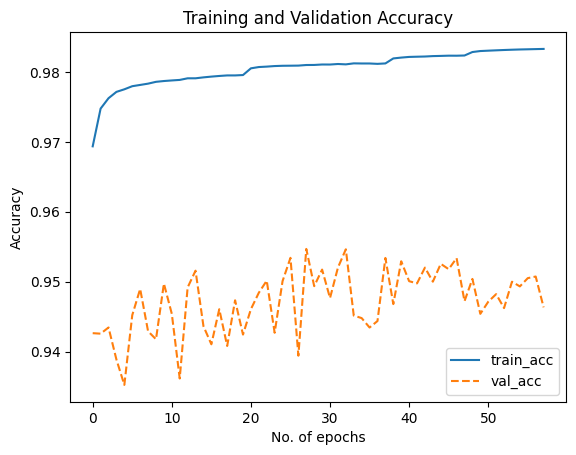

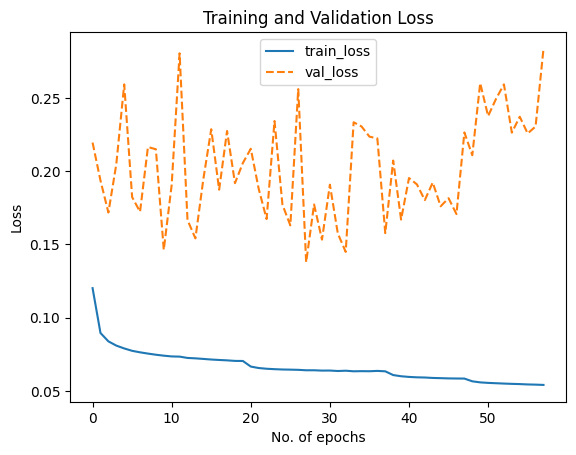

In [27]:
plot_history(history)
np.save('dppnet_road.npy', history.history)

In [28]:
get_flops(dppnetmodel)

0

In [29]:
# dppnetmodel.load_weights('/kaggle/input/dpp-building/dppnet_building.h5')
# dppnetmodel.save('/kaggle/input/dpp-building/dppnet_building.h5')

In [30]:
y_predicted=[]
for i in range(len(x_test)):
    image= np.expand_dims(x_test[i], axis=0)

    y_pred = dppnetmodel.predict(image)
    y_pred=y_pred>0.5
    y_predicted.append(y_pred)



In [ ]:
#dppnetmodel = tf.keras.models.load_model('/kaggle/working/dppnet_building.h5')

y_pred = dppnetmodel.predict(x_test)
y_pred = y_pred>0.5
#y_pred

In [31]:
from sklearn.metrics import *
gt=(y_test.ravel()).astype('int')
pd=(np.array(y_predicted).ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


[0 1] [0 1]
F1 SCORE: 0.808113677536902
Kappa: 0.6168010131686934
Accuracy: 0.9723224337138827
Jaccard Score: 0.716075734962977
Precision: 0.8813032497240261
Recall: 0.7602065000874497


In [35]:
def get_dice(y_true, y_pred):

    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc

dice_coeff = get_dice(y_test, y_predicted)
print("dc = ",np.mean(dice_coeff))

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

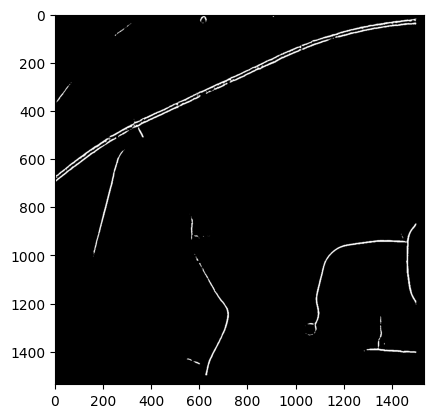

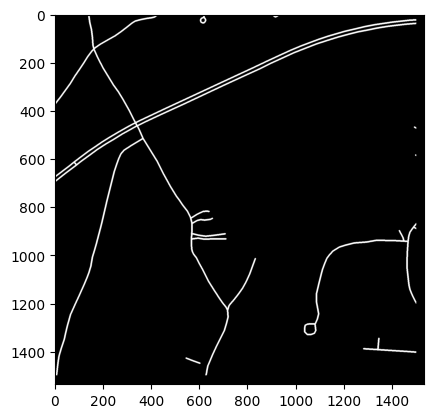

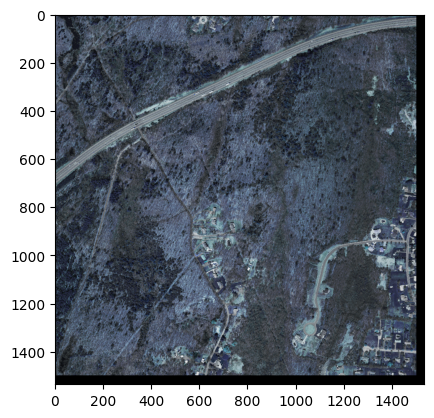

In [32]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

plt.imshow(combined_image_pred, cmap='gray')
plt.show()
plt.imshow(combined_image_test, cmap='gray')
plt.show()
plt.imshow(combined_image_rgb)
plt.show()

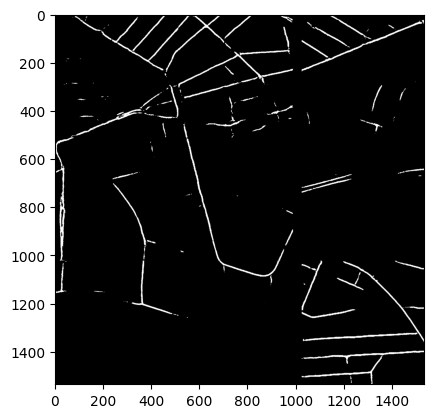

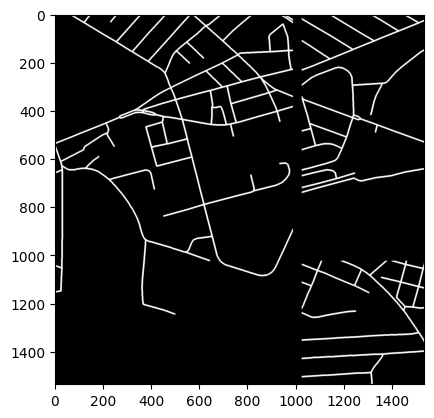

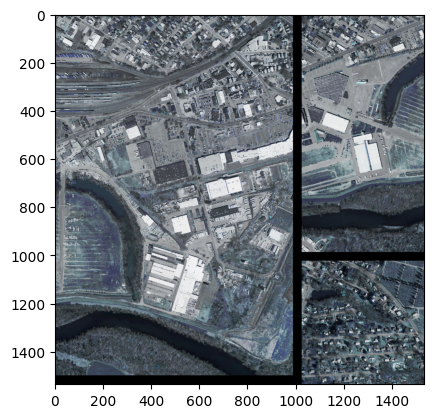

In [33]:
combined_image_rgb = combine_images_rgb(x_test[10:19])
combined_image_test = combine_images_gray(y_test[10:19])
combined_image_pred = combine_images_gray(y_predicted[10:19])

plt.imshow(combined_image_pred, cmap='gray')
plt.show()
plt.imshow(combined_image_test, cmap='gray')
plt.show()
plt.imshow(combined_image_rgb)
plt.show()

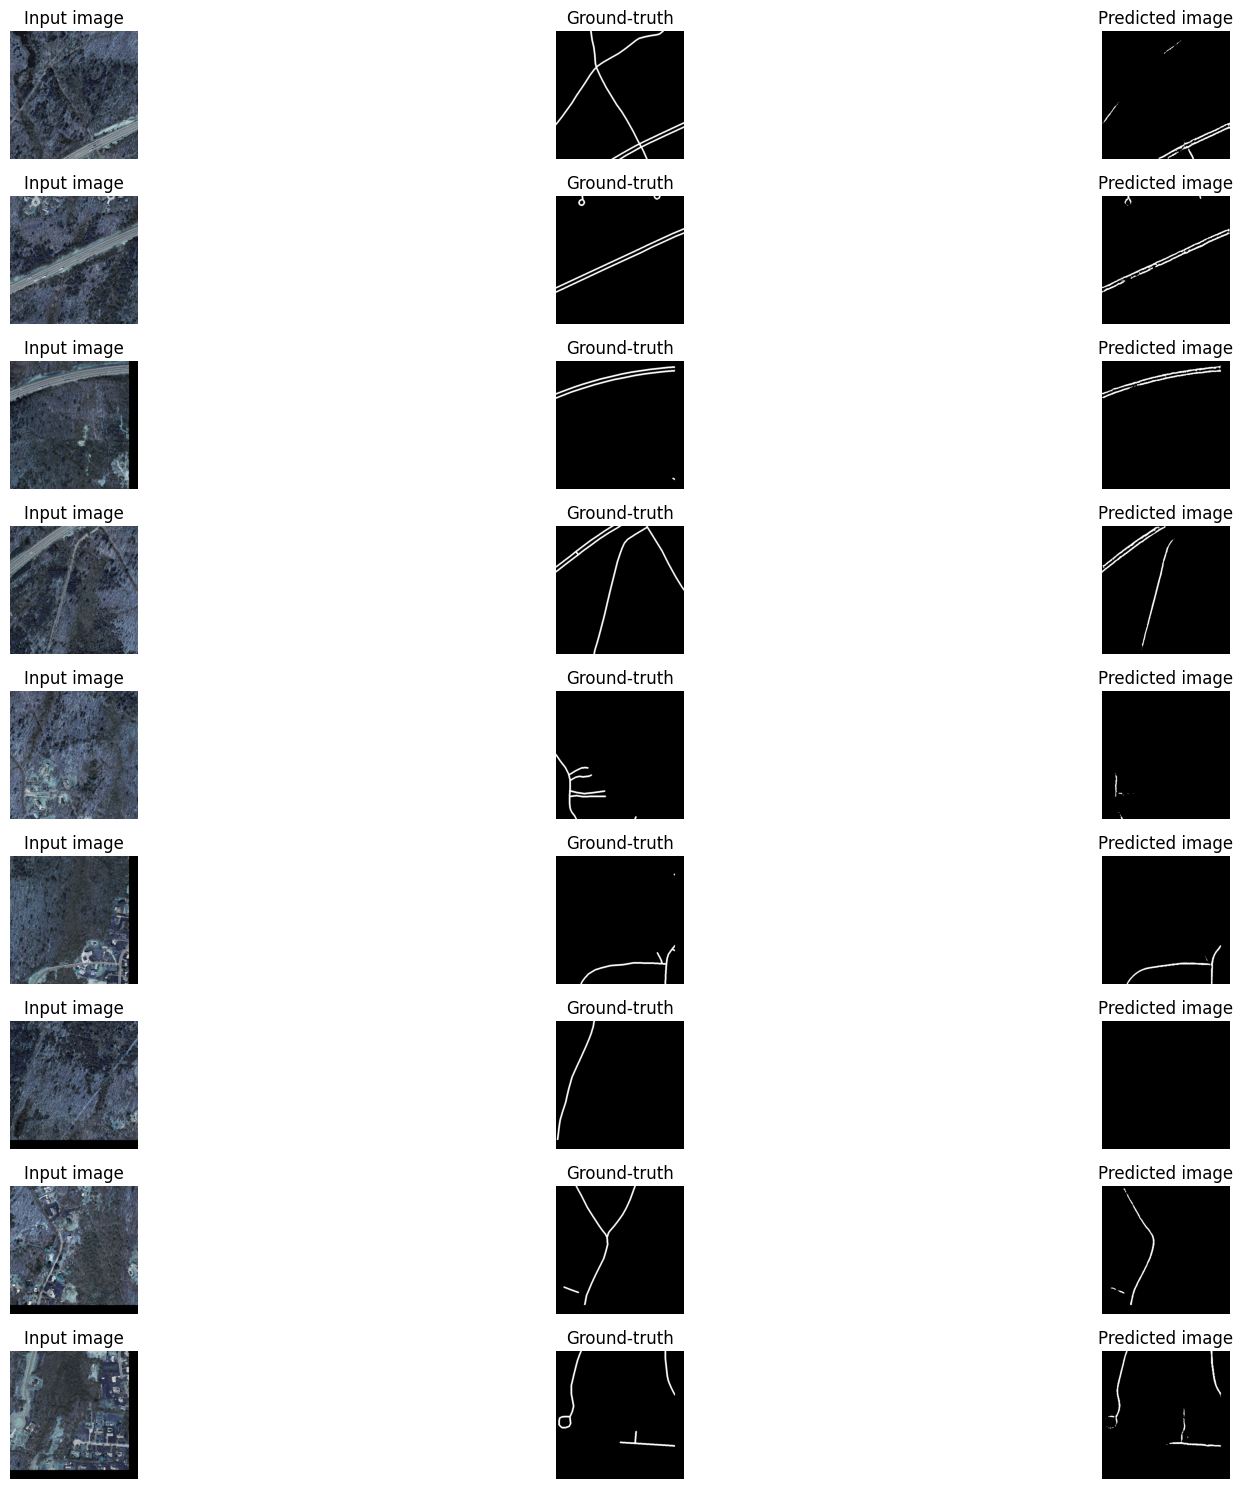

In [34]:
visualize_predictions(x_test, y_test, y_predicted, num_samples=9)

In [ ]:
# fig=plt.figure()
# fig.figsize=(50,50)

# ax=fig.add_subplot(1,2,1)
# ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
# plt.axis('off')
# plt.title("Ground-truth")

# ax=fig.add_subplot(1,2,2)
# ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
# plt.axis('off')
# plt.title("Predicted image")

In [ ]:
evaluation_results_dpp = evaluate_segmentation(y_test, y_pred)
print(evaluation_results_dpp)

# UNET

In [16]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encode module
c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (inputs)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.4) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Decoder module
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, (1, 1)) (c9)
out = Activation('sigmoid')(outputs)

model = Model(inputs=[inputs], outputs=[out])

In [17]:
# define loss function
opt = Adam(learning_rate=0.00002)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', iou_coef])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [18]:
from keras.callbacks import LearningRateScheduler
# Learning Rate Scheduler
def Lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 30
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [ ]:
# model_checkpoint = ModelCheckpoint('./building_unet.h5', monitor='val_loss', save_best_only=True)
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True)

# #lr_scheduler = LearningRateScheduler(Lr_scheduler, verbose=1)
# #history = seg_net_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=1, verbose=1, callbacks=[model_checkpoint,callback], workers=8, use_multiprocessing=True )
# history = model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=50, verbose=1, callbacks=[model_checkpoint,callback])#, workers=8, use_multiprocessing=True )

In [48]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'road_unet.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
history = model.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[model_checkpoint,callback])

Epoch 1/100
309/309 [==============================] - ETA: 0s - loss: 4.2021 - accuracy: 0.7078 - iou_coef: 0.0753
Epoch 00001: val_loss improved from inf to 2.08814, saving model to building_unet.h5
309/309 [==============================] - 83s 245ms/step - loss: 4.2021 - accuracy: 0.7078 - iou_coef: 0.0753 - val_loss: 2.0881 - val_accuracy: 0.7751 - val_iou_coef: 0.0745
Epoch 2/100
309/309 [==============================] - ETA: 0s - loss: 1.9607 - accuracy: 0.7939 - iou_coef: 0.0877
Epoch 00002: val_loss improved from 2.08814 to 1.38125, saving model to building_unet.h5
309/309 [==============================] - 72s 234ms/step - loss: 1.9607 - accuracy: 0.7939 - iou_coef: 0.0877 - val_loss: 1.3813 - val_accuracy: 0.8293 - val_iou_coef: 0.1001
Epoch 3/100
309/309 [==============================] - ETA: 0s - loss: 1.4524 - accuracy: 0.8205 - iou_coef: 0.1171
Epoch 00003: val_loss improved from 1.38125 to 1.14718, saving model to building_unet.h5
309/309 [============================

In [ ]:
type(x_train)

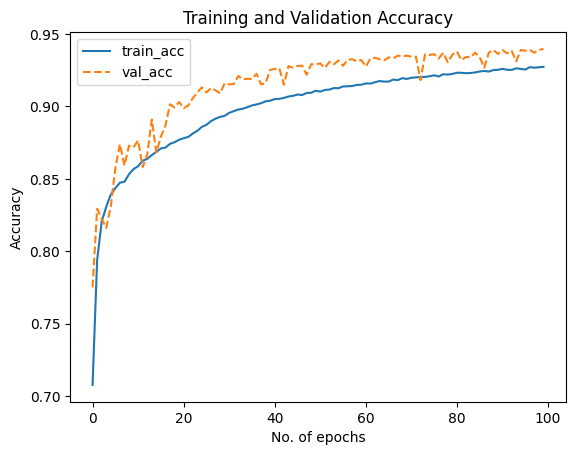

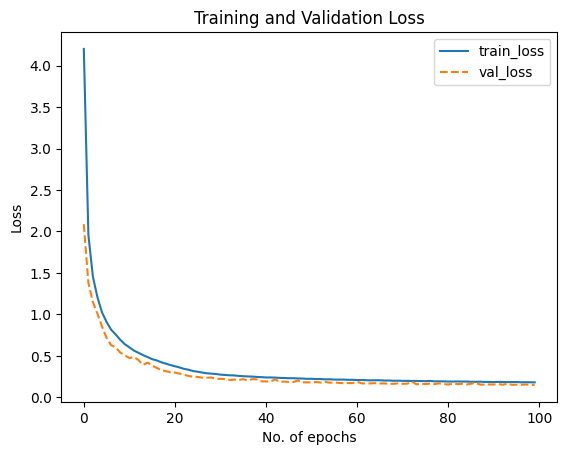

In [49]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
np.save('unet_road.npy', history)

In [50]:
y_pred = model.predict(x_test)
y_pred = y_pred>0.5
#y_pred

In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [51]:
#y_test=y_test.numpy()
#y_pred=y_pred.numpy()

meaniou = MeanIoU(2, name=None, dtype=None)
meaniou.update_state(y_test, y_pred)
class_iou = meaniou.result().numpy()
print("Class-wise IoU =", class_iou)

print("mean IoU = ",meaniou.result().numpy())
meaniou.reset_states()




acc = Accuracy()
acc.update_state(y_test, y_pred)
print("acc = ",acc.result().numpy())
acc.reset_states()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
print(cm)

from sklearn.metrics import classification_report
cr = classification_report(y_test.ravel(), y_pred.ravel())
print(cr)

from sklearn.metrics import cohen_kappa_score
k = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
print("k = ",k)

def get_dice(y_true, y_pred):

    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc

dice_coeff = get_dice(y_test, y_pred)
print("dc = ",np.mean(dice_coeff))

Class-wise IoU = 0.73161685
mean IoU =  0.73161685
acc =  0.90996754
[[18587775   818697]
 [ 1305435  2881053]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95  19406472
         1.0       0.78      0.69      0.73   4186488

    accuracy                           0.91  23592960
   macro avg       0.86      0.82      0.84  23592960
weighted avg       0.91      0.91      0.91  23592960

k =  0.6768507467578623
dc =  0.7306533229151847


In [ ]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

plt.imshow(combined_image_pred, cmap='gray')
plt.show()
plt.imshow(combined_image_test, cmap='gray')
plt.show()
plt.imshow(combined_image_rgb)
plt.show()

# SegNet

In [19]:
def segnet():
    with tf.device('/GPU:0'):
        # Encoding layer
        img_input = Input(shape= (512, 512, 3))
        x = Conv2D(32, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
        x = BatchNormalization(name='bn1')(x)
        x = Activation('relu')(x)
        x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
        x = BatchNormalization(name='bn2')(x)
        x = Activation('relu')(x)
        x = MaxPooling2D()(x)
    
        x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
        x = BatchNormalization(name='bn3')(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
        x = BatchNormalization(name='bn4')(x)
        x = Activation('relu')(x)
        x = MaxPooling2D()(x)

        x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
        x = BatchNormalization(name='bn5')(x)
        x = Activation('relu')(x)
        x = Conv2D(128, (3, 3), padding='same', name='conv6')(x)
        x = BatchNormalization(name='bn6')(x)
        x = Activation('relu')(x)
        x = Conv2D(128, (3, 3), padding='same', name='conv7')(x)
        x = BatchNormalization(name='bn7')(x)
        x = Activation('relu')(x)
        x = MaxPooling2D()(x)

        x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
        x = BatchNormalization(name='bn8')(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same', name='conv9')(x)
        x = BatchNormalization(name='bn9')(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same', name='conv10')(x)
        x = BatchNormalization(name='bn10')(x)
        x = Activation('relu')(x)
        x = MaxPooling2D()(x)
    
        x = Conv2D(256, (3, 3), padding='same', name='conv11')(x)
        x = BatchNormalization(name='bn11')(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same', name='conv12')(x)
        x = BatchNormalization(name='bn12')(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same', name='conv13')(x)
        x = BatchNormalization(name='bn13')(x)
        x = Activation('relu')(x)
        x = MaxPooling2D()(x)

        x = Dense(512, activation = 'relu', name='fc1')(x)
        x = Dense(512, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
        x = UpSampling2D()(x)
        x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
        x = BatchNormalization(name='bn14')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
        x = BatchNormalization(name='bn15')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv3')(x)
        x = BatchNormalization(name='bn16')(x)
        x = Activation('relu')(x)
    
        x = UpSampling2D()(x)
        x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv4')(x)
        x = BatchNormalization(name='bn17')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
        x = BatchNormalization(name='bn18')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv6')(x)
        x = BatchNormalization(name='bn19')(x)
        x = Activation('relu')(x)

        x = UpSampling2D()(x)
        x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv7')(x)
        x = BatchNormalization(name='bn20')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv8')(x)
        x = BatchNormalization(name='bn21')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv9')(x)
        x = BatchNormalization(name='bn22')(x)
        x = Activation('relu')(x)

        x = UpSampling2D()(x)
        x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv10')(x)
        x = BatchNormalization(name='bn23')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv11')(x)
        x = BatchNormalization(name='bn24')(x)
        x = Activation('relu')(x)
    
        x = UpSampling2D()(x)
        x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv12')(x)
        x = BatchNormalization(name='bn25')(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
        x = BatchNormalization(name='bn26')(x)
        pred = Activation('sigmoid')(x)
        #pred = Reshape((512,512))(x)
    
    
        model = Model(inputs=img_input, outputs=pred)
    
#     model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
#                   , metrics=[iou, dice_coef, precision, recall, accuracy])
#     model.summary()
#     hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
#     model.save(savename)
    return model

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dense

def lightweight_segnet():
    # Encoding layer
    img_input = Input(shape=(512, 512, 3))
    x = Conv2D(32, (3, 3), padding='same', name='conv1', strides=(1, 1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn9')(x)
    #x = Activation('relu')(x)
    
#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv4')(x)
#     x = BatchNormalization(name='bn94')(x)
#     x = Activation('relu')(x)

#     x = UpSampling2D()(x)
#     x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv5')(x)
#     x = BatchNormalization(name='bn10')(x)
    pred = Activation('sigmoid')(x)
    
    with tf.device('/GPU:0'):
        model = Model(inputs=img_input, outputs=pred)
    
    #model = Model(inputs=img_input, outputs=pred)
    return model

In [21]:
seg_net_model=lightweight_segnet()
seg_net_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 512, 512, 32)      896       
                                                                 
 bn1 (BatchNormalization)    (None, 512, 512, 32)      128       
                                                                 
 activation_3 (Activation)   (None, 512, 512, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 512, 512, 32)      9248      
                                                                 
 bn2 (BatchNormalization)    (None, 512, 512, 32)      128       
                                                                 
 activation_4 (Activation)   (None, 512, 512, 32)      0   

In [22]:
# define loss function
opt = Adam(learning_rate=0.0002)
seg_net_model.compile(optimizer=opt, loss='binary_crossentropy',metrics=[dice_coef,iou_coef, 'accuracy'])

#print(model.summary())

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'building_segnet.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

#history = seg_net_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=1, verbose=1, callbacks=[model_checkpoint,callback], workers=8, use_multiprocessing=True )
history = seg_net_model.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[model_checkpoint,callback])

Epoch 1/100


In [ ]:
np.save('segnet_building.npy', history)

In [ ]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = seg_net_model.predict(x_test)
y_pred = y_pred>0.5
#y_pred

In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
type(y_test)

In [ ]:
#y_test=y_test.numpy()
#y_pred=y_pred.numpy()

meaniou = MeanIoU(2, name=None, dtype=None)
meaniou.update_state(y_test, y_pred)
class_iou = meaniou.result().numpy()
print("Class-wise IoU =", class_iou)

print("mean IoU = ",meaniou.result().numpy())
meaniou.reset_states()




acc = Accuracy()
acc.update_state(y_test, y_pred)
print("acc = ",acc.result().numpy())
acc.reset_states()
 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
print(cm)
 
from sklearn.metrics import classification_report
cr = classification_report(y_test.ravel(), y_pred.ravel())
print(cr)
 
from sklearn.metrics import cohen_kappa_score
k = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
print("k = ",k)
 
def get_dice(y_true, y_pred):
 
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc
 
dice_coeff = get_dice(y_test, y_pred)
print("dc = ",np.mean(dice_coeff))

In [ ]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

plt.imshow(combined_image_pred, cmap='gray')
plt.show()
plt.imshow(combined_image_test, cmap='gray')
plt.show()
plt.imshow(combined_image_rgb)
plt.show()

# UNET+Attention

In [19]:
def attention_gate(inp_1, inp_2, n_intermediate_channels):
    inp_1_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_1)
    inp_2_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_2)
    f = add([inp_1_conv, inp_2_conv])
    f = Activation('relu')(f)
    g = Conv2D(1, (1, 1), padding='same')(f)
    gate = Activation('sigmoid')(g)

    return multiply([inp_2, gate])

def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = Activation('relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = Activation('relu')(encoder)
    encoder = BatchNormalization()(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([decoder, concat_tensor], axis=-1)
    decoder = conv_block(decoder, num_filters)
    return decoder

def get_attention_unet(input_shape, num_filters_start=16, num_classes=1):
    inputs = Input(input_shape)

    # Downsampling through the model
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start*2)
    encoder_pool2, encoder2 = encoder_block(encoder_pool1, num_filters_start*4)
    encoder_pool3, encoder3 = encoder_block(encoder_pool2, num_filters_start*8)

    center = conv_block(encoder_pool3, num_filters_start*16)

    # Upsampling and establishing the skip connections
    decoder3 = decoder_block(center, encoder3, num_filters_start*8)
    attn3 = attention_gate(encoder3, decoder3, num_filters_start*8)
    decoder2 = decoder_block(attn3, encoder2, num_filters_start*4)
    attn2 = attention_gate(encoder2, decoder2, num_filters_start*4)
    decoder1 = decoder_block(attn2, encoder1, num_filters_start*2)
    attn1 = attention_gate(encoder1, decoder1, num_filters_start*2)
    decoder0 = decoder_block(attn1, encoder0, num_filters_start)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder0)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [20]:
# Define model parameters
input_shape = (512, 512, 3)  # or your preferred dimensions
num_filters_start = 16  # number of filters in the first layer of U-Net
num_classes = 1  # binary segmentation

# Create a new model instance
attention_unet_model = get_attention_unet(input_shape, num_filters_start, num_classes)

In [21]:
print(attention_unet_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
opt = Adam(learning_rate=0.0002)

attention_unet_model.compile(optimizer=opt, loss='binary_crossentropy',metrics=[dice_coef,iou_coef, 'accuracy'])

In [23]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'building_unet_attention.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
#lr_scheduler = LearningRateScheduler(Lr_scheduler, verbose=1)

In [24]:
history = attention_unet_model.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[model_checkpoint,callback])

Epoch 1/100
309/309 [==============================] - ETA: 0s - loss: 0.5899 - dice_coef: 0.2694 - iou_coef: 0.1553 - accuracy: 0.7847
Epoch 00001: val_loss improved from inf to 0.42312, saving model to building_unet.h5
309/309 [==============================] - 109s 312ms/step - loss: 0.5899 - dice_coef: 0.2694 - iou_coef: 0.1553 - accuracy: 0.7847 - val_loss: 0.4231 - val_dice_coef: 0.3001 - val_iou_coef: 0.1715 - val_accuracy: 0.9074
Epoch 2/100
309/309 [==============================] - ETA: 0s - loss: 0.4434 - dice_coef: 0.3273 - iou_coef: 0.1943 - accuracy: 0.8925
Epoch 00002: val_loss improved from 0.42312 to 0.34227, saving model to building_unet.h5
309/309 [==============================] - 92s 298ms/step - loss: 0.4434 - dice_coef: 0.3273 - iou_coef: 0.1943 - accuracy: 0.8925 - val_loss: 0.3423 - val_dice_coef: 0.3640 - val_iou_coef: 0.2117 - val_accuracy: 0.9265
Epoch 3/100
309/309 [==============================] - ETA: 0s - loss: 0.3551 - dice_coef: 0.3654 - iou_coef: 0.2

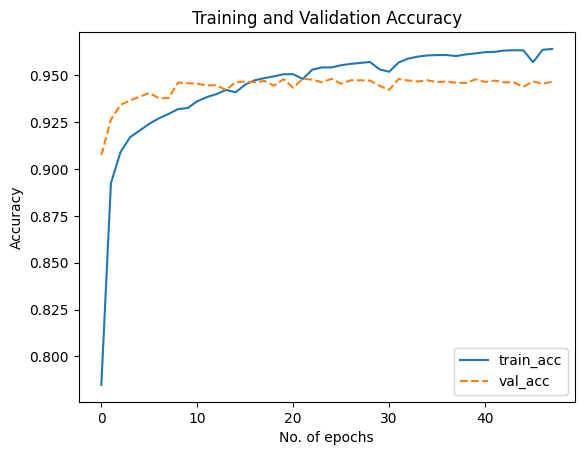

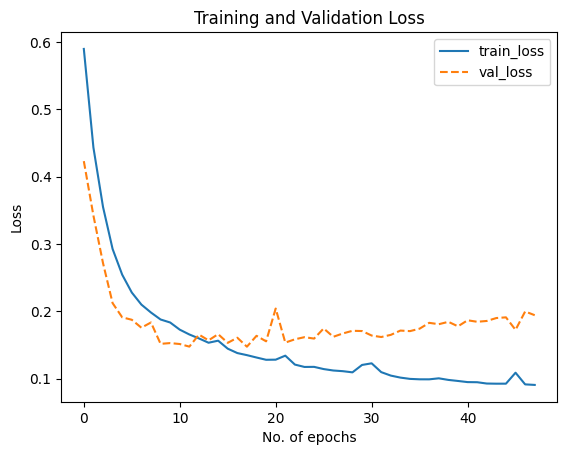

In [25]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [50]:
np.save('unet_attention_building.npy',history.history)

In [31]:
y_pred = attention_unet_model.predict(x_test)
y_pred = y_pred>0.5

In [ ]:
#y_pred<0.5

In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [32]:
meaniou = MeanIoU(2, name=None, dtype=None)
meaniou.update_state(y_test, y_pred)
print("mean IoU = ",meaniou.result().numpy())
meaniou.reset_states()
 
acc = Accuracy()
acc.update_state(y_test, y_pred)
print("acc = ",acc.result().numpy())
acc.reset_states()
 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
print(cm)
 
from sklearn.metrics import classification_report
cr = classification_report(y_test.ravel(), y_pred.ravel())
print(cr)
 
from sklearn.metrics import cohen_kappa_score
k = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
print("k = ",k)
 
def get_dice(y_true, y_pred):
 
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc
 
dice_coeff = get_dice(y_test, y_pred)
print("dc = ",np.mean(dice_coeff))

mean IoU =  0.7224628
acc =  0.90946835
[[18762130   644342]
 [ 1491569  2694919]]
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95  19406472
         1.0       0.81      0.64      0.72   4186488

    accuracy                           0.91  23592960
   macro avg       0.87      0.81      0.83  23592960
weighted avg       0.91      0.91      0.91  23592960

k =  0.6631410498751704
dc =  0.7161862560125245


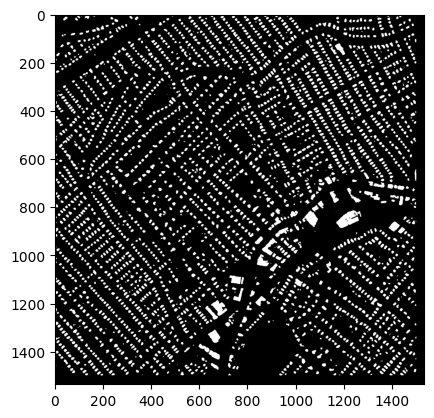

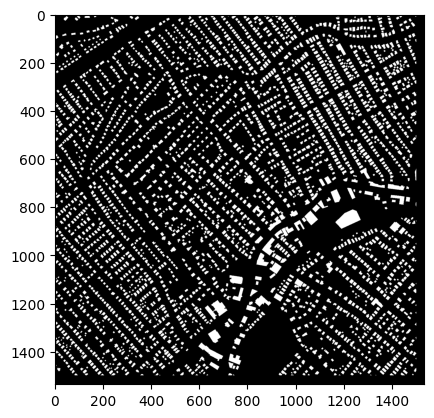

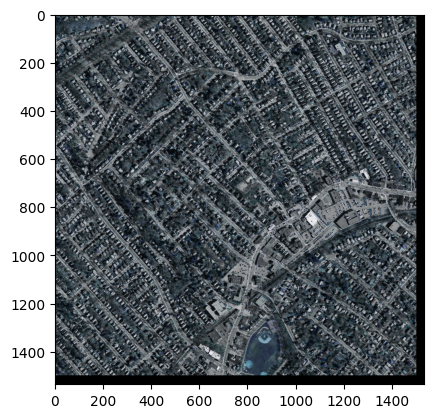

In [33]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_pred[0:9])

# plt.imshow(combined_image_pred, cmap='gray')
# plt.show()
# plt.imshow(combined_image_test, cmap='gray')
# plt.show()
# plt.imshow(combined_image_rgb)
# plt.show()

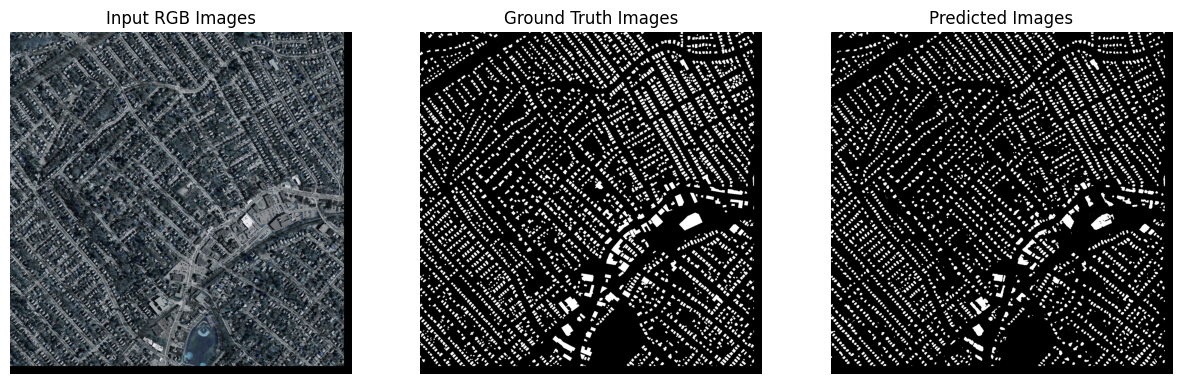

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(combined_image_rgb)
axes[0].set_title('Input RGB Images')
axes[0].axis('off')



axes[1].imshow(combined_image_test, cmap='gray')
axes[1].set_title('Ground Truth Images')
axes[1].axis('off')

axes[2].imshow(combined_image_pred, cmap='gray')
axes[2].set_title('Predicted Images')
axes[2].axis('off')



plt.show()

# UNET++

In [36]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
    # Applying the sequence of Convolutional, Batch Normalization
    # and Activation Layers to the input tensor
    x = tf.keras.Sequential([
        # Convolutional Layer
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        # Batch Normalization Layer
        tf.keras.layers.BatchNormalization(),
        # Activation Layer
        tf.keras.layers.Activation('relu'),
        # Convolutional Layer
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        # Batch Normalization Layer
        tf.keras.layers.BatchNormalization(),
        # Activation Layer
        tf.keras.layers.Activation('relu')
    ])(inputs)
 
    # Returning the output of the Convolutional Block
    return x

In [37]:
# Defining the Unet++ Model
def unet_plus_plus_model(input_shape=(256, 256, 3), num_classes=1, deep_supervision=True):
	inputs = tf.keras.layers.Input(shape=input_shape)

	# Encoding Path
	x_00 = conv_block(inputs, 64)
	x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
	x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
	x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
	x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)

	# Nested Decoding Path
	x_01 = conv_block(tf.keras.layers.concatenate(
		[x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
	x_11 = conv_block(tf.keras.layers.concatenate(
		[x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
	x_21 = conv_block(tf.keras.layers.concatenate(
		[x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
	x_31 = conv_block(tf.keras.layers.concatenate(
		[x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)

	x_02 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
	x_12 = conv_block(tf.keras.layers.concatenate(
		[x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
	x_22 = conv_block(tf.keras.layers.concatenate(
		[x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)

	x_03 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
	x_13 = conv_block(tf.keras.layers.concatenate(
		[x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)

	x_04 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)

	# Deep Supervision Path
	# If deep supervision is enabled, then the model will output the segmentation maps
	# at each stage of the decoding path
	if deep_supervision:
		outputs = [
			tf.keras.layers.Conv2D(num_classes, 1)(x_01),
			tf.keras.layers.Conv2D(num_classes, 1)(x_02),
			tf.keras.layers.Conv2D(num_classes, 1)(x_03),
			tf.keras.layers.Conv2D(num_classes, 1)(x_04)
		]
		# Concatenating the segmentation maps
		outputs = tf.keras.layers.concatenate(outputs, axis=0)

	# If deep supervision is disabled, then the model will output the final segmentation map
	# which is the segmentation map at the end of the decoding path
	else:
		outputs = tf.keras.layers.Conv2D(num_classes, 1)(x_04)

	# Creating the model
	model = tf.keras.Model(
		inputs=inputs, outputs=outputs, name='Unet_plus_plus')

	# Returning the model
	return model

In [38]:
def conv_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def unet_plusplus_low_complexity(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Middle Block
    conv5 = conv_block(pool4, 512)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv5)
    concat4 = Concatenate()([up4, conv4])
    conv6 = conv_block(concat4, 256)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    concat3 = Concatenate()([up3, conv3])
    conv7 = conv_block(concat3, 128)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    concat2 = Concatenate()([up2, conv2])
    conv8 = conv_block(concat2, 64)

    up1 = UpSampling2D(size=(2, 2))(conv8)
    concat1 = Concatenate()([up1, conv1])
    conv9 = conv_block(concat1, 32)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    with tf.device('/GPU:0'):
        model = tf.keras.models.Model(inputs=inputs, outputs=output)
    return model

In [39]:
unet_plus_plusmodel = unet_plusplus_low_complexity(input_shape=(
		512, 512, 3))

	# Printing the model summary
unet_plus_plusmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 512, 512, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 32  128        ['conv2d_28[0][0]']              
 ormalization)                  )                                                           

In [40]:
opt = Adam(learning_rate=0.0002)

unet_plus_plusmodel.compile(optimizer=opt, loss=bce_dice_loss,metrics=[dice_coef,iou_coef, 'accuracy'])

In [42]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'building_unet_plus_plus.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
#lr_scheduler = LearningRateScheduler(Lr_scheduler, verbose=1)

In [52]:
history = unet_plus_plusmodel.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[model_checkpoint,callback])

Epoch 1/100
309/309 [==============================] - ETA: 0s - loss: 0.7475 - dice_coef: 0.3059 - iou_coef: 0.1752 - accuracy: 0.8538
Epoch 00001: val_loss improved from inf to 0.53618, saving model to building_unet_plus_plus.h5
309/309 [==============================] - 221s 676ms/step - loss: 0.7475 - dice_coef: 0.3059 - iou_coef: 0.1752 - accuracy: 0.8538 - val_loss: 0.5362 - val_dice_coef: 0.3941 - val_iou_coef: 0.2329 - val_accuracy: 0.9260
Epoch 2/100
309/309 [==============================] - ETA: 0s - loss: 0.5728 - dice_coef: 0.4073 - iou_coef: 0.2470 - accuracy: 0.9037
Epoch 00002: val_loss improved from 0.53618 to 0.47642, saving model to building_unet_plus_plus.h5
309/309 [==============================] - 205s 663ms/step - loss: 0.5728 - dice_coef: 0.4073 - iou_coef: 0.2470 - accuracy: 0.9037 - val_loss: 0.4764 - val_dice_coef: 0.4715 - val_iou_coef: 0.2927 - val_accuracy: 0.9223
Epoch 3/100
309/309 [==============================] - ETA: 0s - loss: 0.4985 - dice_coef: 0

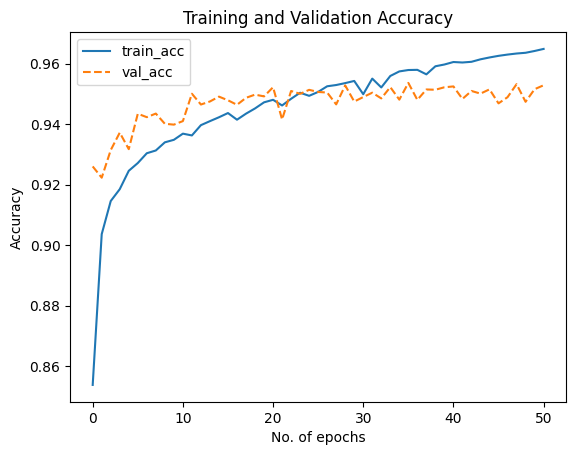

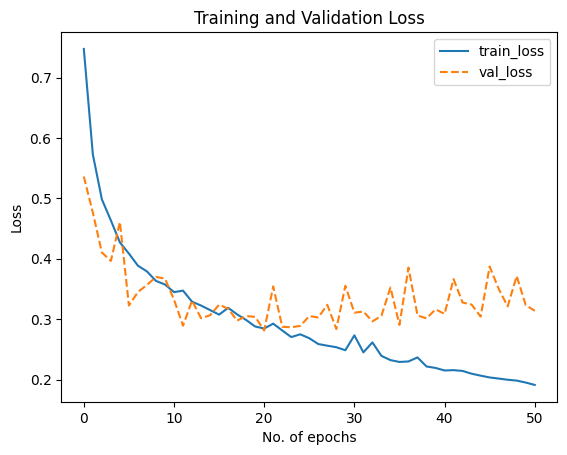

In [55]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [56]:
np.save('unet_plus_plus_building.npy', history.history)

In [59]:
y_predicted=[]
for i in range(len(x_test)):
    image= np.expand_dims(x_test[i], axis=0)

    y_pred = unet_plus_plusmodel.predict(image)
    y_pred=y_pred>0.5
    y_predicted.append(y_pred)

In [64]:
from sklearn.metrics import *
gt=(y_test.ravel()).astype('int')
pd=(np.array(y_predicted).ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)
 
def get_dice(y_true, y_pred):
 
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc
 
dice_coeff = get_dice(y_test, y_predicted.numpy())
print("dc = ",np.mean(dice_coeff))

[0 1] [0 1]
F1 SCORE: 0.865902913283549
Kappa: 0.7319014583383855
Accuracy: 0.9241930643717448
Jaccard Score: 0.7743004881151382
Precision: 0.8787620284413271
Recall: 0.8544667741932217


AttributeError: 'list' object has no attribute 'numpy'

In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [62]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

# plt.imshow(combined_image_pred, cmap='gray')
# plt.show()
# plt.imshow(combined_image_test, cmap='gray')
# plt.show()
# plt.imshow(combined_image_rgb)
# plt.show()

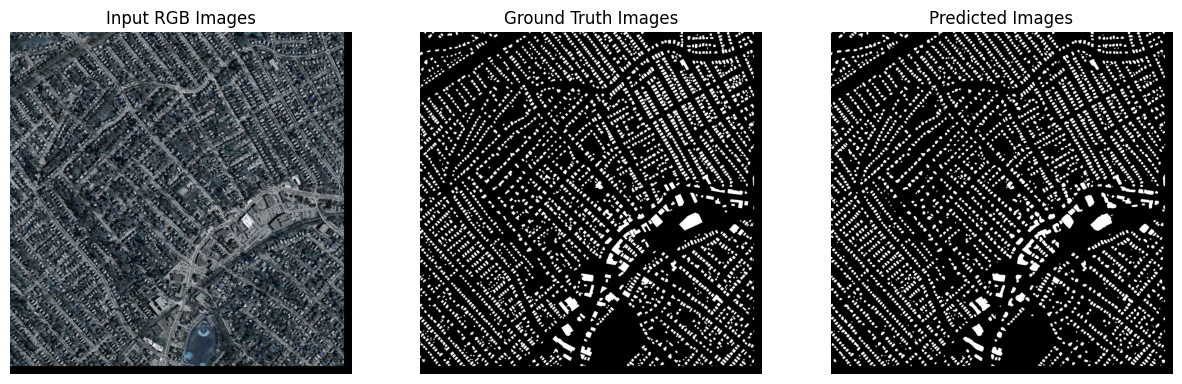

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(combined_image_rgb)
axes[0].set_title('Input RGB Images')
axes[0].axis('off')



axes[1].imshow(combined_image_test, cmap='gray')
axes[1].set_title('Ground Truth Images')
axes[1].axis('off')

axes[2].imshow(combined_image_pred, cmap='gray')
axes[2].set_title('Predicted Images')
axes[2].axis('off')

plt.show()

# HRNET

In [20]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    # x = BatchNormalization(axis=3)(x)
    # x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))

    x = stem_net(inputs)

    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model


# from keras.utils import plot_model
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#

# plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

In [21]:
model = seg_hrnet(batch_size=1, height=512, width=512, channel=3, classes=1)
#model.summary()

In [22]:
class ParallelModelCheckpoint(ModelCheckpoint):
    def __init__(self,model,filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        self.single_model = model
        super(ParallelModelCheckpoint,self).__init__(filepath, monitor, verbose,save_best_only, save_weights_only,mode, period)

    def set_model(self, model):
        super(ParallelModelCheckpoint,self).set_model(self.single_model)

In [23]:
#paralle_model = multi_gpu_model(model, gpus=4)
opt = Adam(learning_rate=0.0002)

model.compile(optimizer=opt, loss=bce_dice_loss,metrics=[dice_coef,iou_coef, 'accuracy'])
#model_path = "seg_hrnet-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}-{val_iou:.4f}.hdf5"
#model_checkpoint = ParallelModelCheckpoint(model, model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

In [24]:
from keras.callbacks import ReduceLROnPlateau

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'building_hrnet.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
#lr_scheduler = LearningRateScheduler(Lr_scheduler, verbose=1)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2)
check_point_list = [model_checkpoint, callback]

In [ ]:
result = model.fit(
    train_gen, validation_data=val_gen, epochs=100, verbose=1,
    callbacks=check_point_list)

Epoch 1/100
1233/1233 [==============================] - ETA: 0s - loss: 0.9473 - dice_coef: 0.2745 - iou_coef: 0.1673 - accuracy: 0.8218
Epoch 00001: val_loss improved from inf to 0.83516, saving model to building_unet_plus_plus.h5
1233/1233 [==============================] - 509s 411ms/step - loss: 0.9473 - dice_coef: 0.2745 - iou_coef: 0.1673 - accuracy: 0.8218 - val_loss: 0.8352 - val_dice_coef: 0.2892 - val_iou_coef: 0.1752 - val_accuracy: 0.9029
Epoch 2/100
1233/1233 [==============================] - ETA: 0s - loss: 0.8174 - dice_coef: 0.3156 - iou_coef: 0.1987 - accuracy: 0.8918
Epoch 00002: val_loss improved from 0.83516 to 0.74114, saving model to building_unet_plus_plus.h5
1233/1233 [==============================] - 506s 410ms/step - loss: 0.8174 - dice_coef: 0.3156 - iou_coef: 0.1987 - accuracy: 0.8918 - val_loss: 0.7411 - val_dice_coef: 0.3057 - val_iou_coef: 0.1874 - val_accuracy: 0.9314
Epoch 3/100
1233/1233 [==============================] - ETA: 0s - loss: 0.7332 - di

In [27]:
model.load_weights(r"C:\Users\shyamlal\Documents\Building_Road_Segm\Unet_others\building_unet_plus_plus.h5")

In [ ]:
plt.plot(result.history['accuracy'] , label = 'train_acc')
plt.plot(result.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(result.history['loss'] , label = 'train_loss')
plt.plot(result.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
np.save('hrnet_building.npy', result.history)

In [ ]:
# y_pred = model.predict(x_test)
# y_pred = y_pred>0.5

In [30]:
y_predicted=[]
for i in range(len(x_test)):
    image= np.expand_dims(x_test[i], axis=0)

    y_pred = model.predict(image)
    y_pred=y_pred>0.5
    y_predicted.append(y_pred)



In [ ]:
fig=plt.figure()
fig.figsize=(50,50)

ax=fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[4],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [ ]:
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_test[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_pred[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [33]:
from sklearn.metrics import *
gt=(y_test.ravel()).astype('int')
pd=(np.array(y_predicted).ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)
 
def get_dice(y_true, y_pred):
 
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc
 
dice_coeff = get_dice(y_test, y_predicted.numpy())
print("dc = ",np.mean(dice_coeff))

[0 1] [0 1]
F1 SCORE: 0.8604286230461378
Kappa: 0.7213708018931471
Accuracy: 0.9243444654676649
Jaccard Score: 0.7671854237314883
Precision: 0.8930986047006968
Recall: 0.8354911510519951


AttributeError: 'list' object has no attribute 'numpy'

In [ ]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

# plt.imshow(combined_image_pred, cmap='gray')
# plt.show()
# plt.imshow(combined_image_test, cmap='gray')
# plt.show()
# plt.imshow(combined_image_rgb)
# plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(combined_image_rgb)
axes[0].set_title('Input RGB Images')
axes[0].axis('off')

axes[1].imshow(combined_image_test, cmap='gray')
axes[1].set_title('Ground Truth Images')
axes[1].axis('off')



axes[2].imshow(combined_image_pred, cmap='gray')
axes[2].set_title('Predicted Images')
axes[2].axis('off')

plt.show()